In [17]:
import os

os.chdir("D:\\Documents\\GitHub\\medical-imaging-evaluation")

In [255]:
import cv2
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt
from sklearn.base import BaseEstimator, ClassifierMixin, RegressorMixin
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV, cross_validate, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVR, SVC
from sklearn.cluster import DBSCAN


from model.metrics.metrics_wrapper import Metrics

from sklearn.metrics import jaccard_score


sns.set()

In [316]:
train_eval = pd.read_csv('data/OpenPart.csv')
test_eval = pd.read_csv('data/SecretPart_dummy.csv')
train_eval.head()

,Case,Sample 1,Sample 2,Sample 3
0,00000072_000.png,1,5,1
1,00000150_002.png,5,5,3
2,00000181_061.png,4,4,3
3,00000211_019.png,4,4,2
4,00000211_041.png,3,5,2


In [31]:
train_names = train_eval['Case'].to_numpy()
test_names = test_eval['Case'].to_numpy()
val_indices = np.random.choice(train_names.shape[0], 0, replace=False)
train_indices = [i for i in range(len(train_names)) if i not in val_indices]
val_names = train_names[val_indices]
train_names = train_names[train_indices]
train_label = train_eval.iloc[train_indices]
val_label = train_eval.iloc[val_indices]
print('train size =', len(train_names))
print('validation size =', len(val_names))

train size = 60
validation size = 0


In [32]:
def load_data(names, folder, ending):
    data = []
    for name in names:
        image = cv2.imread(folder + '/' + name.split('.')[0] + ending + '.png', 0)
#         image = (image > 10).astype(np.int_)
        data.append(image)
    return np.array(data)

train_data = [
    load_data(train_names, 'data/sample_1', '_s1'),
    load_data(train_names, 'data/sample_2', '_s2'),
    load_data(train_names, 'data/sample_3', '_s3')
]
val_data = [
    load_data(val_names, 'data/sample_1', '_s1'),
    load_data(val_names, 'data/sample_2', '_s2'),
    load_data(val_names, 'data/sample_3', '_s3')
]
test_data = [
    load_data(test_names, 'data/sample_1', '_s1'),
    load_data(test_names, 'data/sample_2', '_s2'),
    load_data(test_names, 'data/sample_3', '_s3')
]
expert_train = load_data(train_names, 'data/expert', '_expert')
expert_val = load_data(val_names, 'data/expert', '_expert')
expert_test = load_data(test_names, 'data/expert', '_expert')

In [ ]:
for i in range(len(test_data[0])):
    plt.subplot(1, 2, 1)
    plt.imshow(test_data[0][i])
    plt.subplot(1, 2, 2)
    plt.imshow()

## Кластеризация (признана мало подходящим способом улучшения данных)

In [229]:
def convert_to_table(img):
    elements = []
    for i in range(len(img)):
        for j in range(len(img[i])):
            if img[i][j] > 0:
                elements.append([i, j])
    return pd.DataFrame(elements)

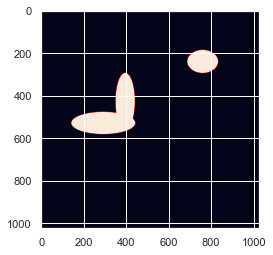

In [312]:
plt.imshow(expert_train[11])

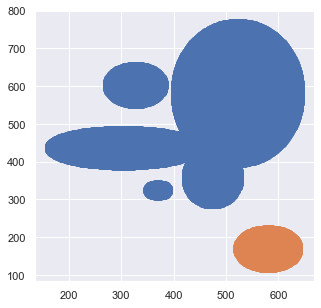

In [311]:
dbscan = DBSCAN(eps=40)
pred = dbscan.fit_predict(img_table)
plt.figure(figsize=(5,5))
for cl in np.unique(pred):
    cl_inds = [i for i in range(len(pred)) if pred[i] == cl]
    plt.scatter(img_table[0].iloc[cl_inds], img_table[1].iloc[cl_inds])
plt.show()

## Подсчёт метрик и построение модели

In [225]:
def compute_metrics(ex, pred):
    if ex.sum() == 0 and pred.sum() == 0:
        return [0] * 7
    elif ex.sum() == 0 or pred.sum() == 0:
        return [-1] * 7
    metrics = Metrics(ex, pred)
    result = []
    result.append(metrics.average_surface_distance())
    result.append(metrics.dice_coefficient())
    result.append(metrics.robust_hausdorff(0))
    result.append(metrics.robust_hausdorff(50))
    result.append(metrics.robust_hausdorff(100))
    result.append(metrics.surface_overlap_tolerance())
    result.append(metrics.dice_coefficient_tolerance())
    return result

def make_dataframe(expert, predicted):
    data = []
    for i in range(len(expert)):
        metrics = compute_metrics(expert[i], predicted[i])
        row = []
        for m in metrics:
            if type(m) == tuple:
                row.append(m[0])
                row.append(m[1])
            else:
                row.append(m)
        data.append(np.array(row))
    return pd.DataFrame(data)

In [133]:
class RoundRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, model, round_model=True):
        self.model = model
        self.round_model = round_model
        
    def fit(self, X, y):
        self.model.fit(X, y)
        return self
    
    def predict(self, X):
        pred = self.model.predict(X)
        if self.round_model:
            pred = np.round(pred, 0)
        return pred

### Простейшая модель с одной метрикой

In [197]:
def make_dataframe_jaccard_score(expert, predicted):
    data = []
    for i in range(len(expert)):
        row = [jaccard_score((expert[i].reshape(1, -1)[0] > 0).astype(int),
                             (predicted[i].reshape(1, -1)[0] > 0).astype(int))]
        data.append(np.array(row))
    return pd.DataFrame(data)

## baseline test
base_df = pd.concat([
    make_dataframe_jaccard_score(expert_train, train_data[0]).fillna(-1),
    make_dataframe_jaccard_score(expert_train, train_data[1]).fillna(-1),
    make_dataframe_jaccard_score(expert_train, train_data[2]).fillna(-1)
])

scaler = StandardScaler()
base_df = scaler.fit_transform(base_df)
models = [LinearRegression(), RandomForestRegressor(), GradientBoostingClassifier(),
          KNeighborsRegressor(), KNeighborsClassifier(), RandomForestClassifier(), SVC(), SVR(),
         GaussianNB()] #LogisticRegression(), 
skf = StratifiedKFold(n_splits=3)
for model in models:
    print(model, end=': ')
    rounded = cross_validate(estimator=RoundRegressor(model), X=base_df, y=labels,
                   scoring='neg_mean_absolute_error', cv=skf)['test_score']
    print(rounded.mean())

LinearRegression(): -0.8055555555555557
RandomForestRegressor(): -0.9111111111111111
GradientBoostingClassifier(): -0.8722222222222222
KNeighborsRegressor(): -0.9055555555555556
KNeighborsClassifier(): -0.85
RandomForestClassifier(): -0.8722222222222222
SVC(): -0.7833333333333333
SVR(): -0.8055555555555557
GaussianNB(): -0.8444444444444444


### Большее количество метрик

<AxesSubplot:>

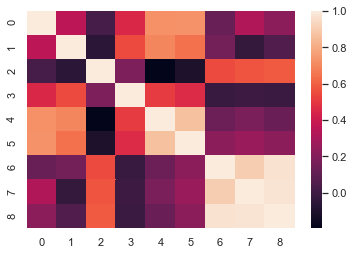

In [226]:
df = pd.concat([
    make_dataframe(expert_train, train_data[0]).fillna(-1),
    make_dataframe(expert_train, train_data[1]).fillna(-1),
    make_dataframe(expert_train, train_data[2]).fillna(-1)
])
sns.heatmap(df.corr(method="spearman"))

In [227]:
labels = pd.concat([train_label['Sample 1'], train_label['Sample 2'], train_label['Sample 3']])

In [228]:
scaler = StandardScaler()
df = scaler.fit_transform(df)
models = [LinearRegression(), RandomForestRegressor(), GradientBoostingClassifier(),
          KNeighborsRegressor(), KNeighborsClassifier(), RandomForestClassifier(), SVC(), SVR(),
         GaussianNB()] #LogisticRegression(), 
skf = StratifiedKFold(n_splits=3)
for model in models:
    print(model, end=': ')
    rounded = cross_validate(estimator=RoundRegressor(model), X=df, y=labels,
                   scoring='neg_mean_absolute_error', cv=skf)['test_score']
    print(rounded.mean())
#     not_rounded = cross_validate(estimator=RoundRegressor(model, False), X=df, y=labels,
#                                  scoring='neg_mean_absolute_error', cv=skf)['test_score']
#     print(not_rounded, not_rounded.mean())

LinearRegression(): -0.5833333333333334
RandomForestRegressor(): -0.5833333333333334
GradientBoostingClassifier(): -0.5388888888888889
KNeighborsRegressor(): -0.6277777777777778
KNeighborsClassifier(): -0.6722222222222222
RandomForestClassifier(): -0.5499999999999999
SVC(): -0.5277777777777778
SVR(): -0.5388888888888889
GaussianNB(): -0.5888888888888889


In [44]:
make_dataframe(expert_train, train_data[0])

,0,1,2,3,4,5,6,7,8
0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,NaN,NaN
1,16.464139,14.026719,0.520065,9.848858,14.422205,30.066593,0.000000,0.000000,0.000000
2,55.568461,132.595403,0.519559,0.000000,84.899941,460.651712,0.013096,0.005527,0.008180
3,65.103659,98.168188,0.708670,0.000000,61.294372,361.247837,0.002758,0.001580,0.002133
4,64.969084,190.933578,0.562957,0.000000,113.000000,610.921435,0.016498,0.009258,0.011927
5,52.766829,341.206378,0.169319,0.000000,369.855377,742.752314,0.008731,0.001494,0.002552
6,11.527321,250.449771,0.244048,0.000000,226.850171,637.134994,0.068644,0.012223,0.022072
7,51.646097,169.683376,0.233938,0.000000,148.822041,523.197859,0.030655,0.009543,0.014542
8,17.967957,150.712894,0.243452,0.000000,128.701204,430.345210,0.021492,0.005776,0.008853
9,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,NaN,NaN


00000072_000.png


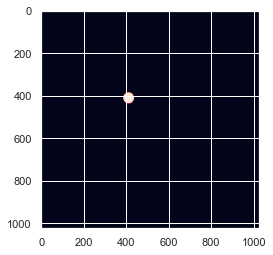

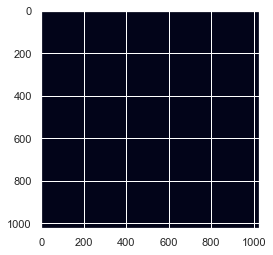

00000150_002.png


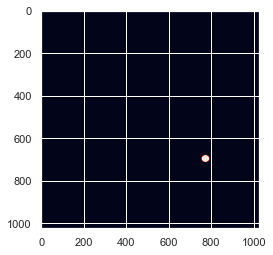

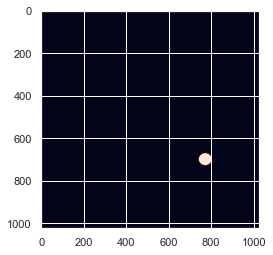

00000181_061.png


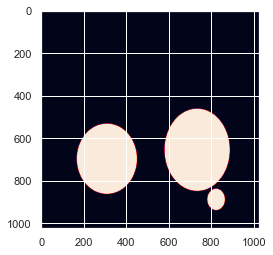

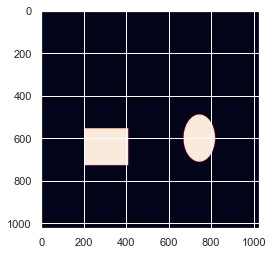

00000211_019.png


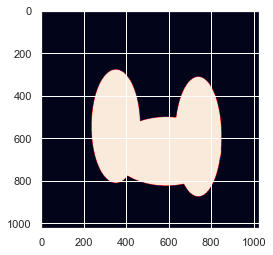

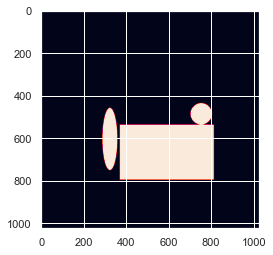

00000211_041.png


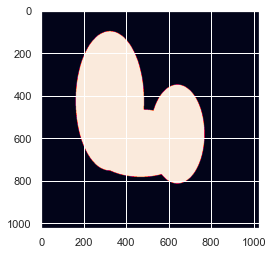

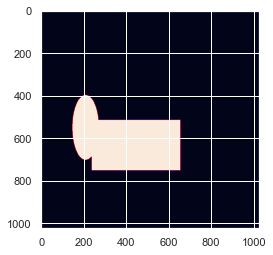

00000344_003.png


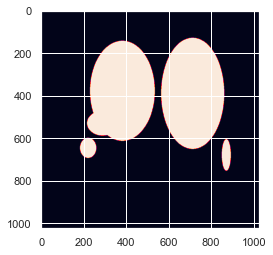

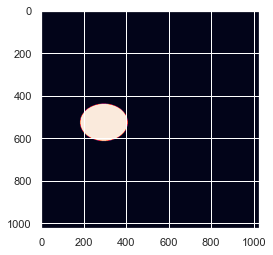

00000468_033.png


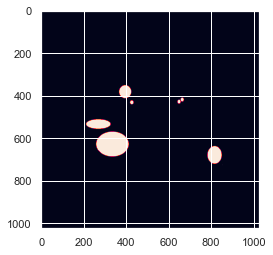

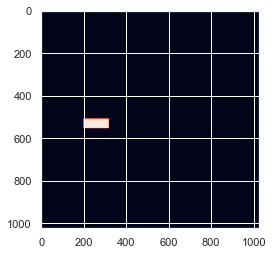

00000808_002.png


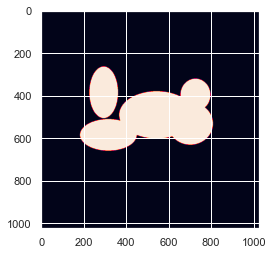

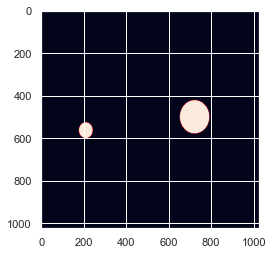

00000830_000.png


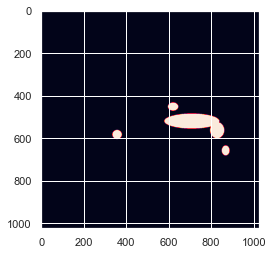

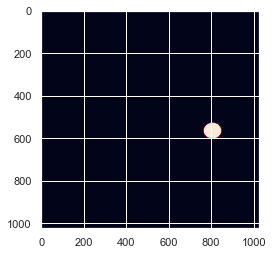

00000974_002.png


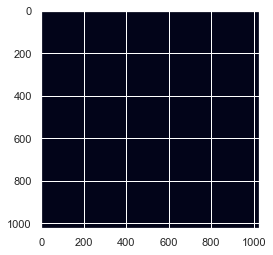

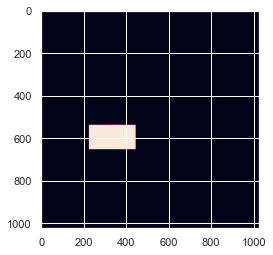

In [233]:
for i in range(0, 10):
    print(train_names[i])
    plt.imshow(train_data[0][i])
    plt.show()
    plt.imshow(expert_train[i])
    plt.show()